# Creating gymnasium environment

### Explanations

The environment is:
 - A $N \times M$ grid of cases with $N,M \in \mathbb{N}$ supposed to be a loop track.
 - Each case is in $\{0,1,3,4\}$ such that:
   - $0 \rightarrow$ road (white)
   - $1 \rightarrow$ wall (black)
   - $STAR\_ CHAR$ (3) $\rightarrow$ starting point

 - A Car that follow some model for trajectory. The car can do the next action:
   - accelerate (add $1$ to car speed)
   - brake (divide the car speed by $1.5$)
   - turn (need to specify the angle)
   - do nothing
  
 - Possible Actions $(a,b) \in \{-1,0,1\} \times [-K,K]$ where:
   - $a=1$ for acceleration, $-1$ for brake and $0$ for nothing
   - $b>0$ for turning left with angle, $b<0$ to turn right and 0 for nothing. Note that a turn, in this environment is always in $[-K,K]$ where $K$ is the value of `env.max_turn` variable.

To create your turn/your track, use the grid notation (for better visualisation) like env_01 and env_02. The grid is used with the matrix notation. If we denote the grid by $G$, then $G[0][0]$ is the top left case, $G[x][y]$ is the case on the $x$-th row (from top to bottom) and on the $y$-th column (from left to right).

You can also use image for that with balck pixel for wall, white for starting point, any other color will be interpreted as road.

Nevertheless, for all the other things, we use axis coordinates, i.e., $G[x][y]$ refer to the case situate at coordinate $(x,y)$. More preciselly, it is the case on the $x$-th column (from left to right) and on the $y$-th row (from bottom to top). Therefore you can simply use `plt.plot(x,y, args**)` for ploting something at coordinate $(x,y)$ (see code for more example).

### Importing Packages

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import random as rd
import time

from gym import Env, spaces

### Coor class

In [10]:
class Coor():
    def __init__(self, coor):
        self.x = coor[0]
        self.y = coor[1]

    def get(self):
        return self.x, self.y
    
    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ")"
    
    def __add__(self, coor2):
        return Coor((self.x + coor2.x, self.y + coor2.y))
    
    def __eq__(self, coor2):
        if coor2 == None:
            return False
        return (self.x==coor2.x) and (self.y==coor2.y)
    
    def __neg__(self):
        x,y = self.get()
        return Coor((-x,-y))
    
    def __sub__(self, coor2):
        coor = - coor2
        return self + coor
    
    def norm(self):
        x,y = self.get()
        return np.sqrt(x*x + y*y)
    
    def dist(self, coor2):
        return (self -coor2).norm()


### Track class

Contrary to previous environment, track are not matrix anymore.

In [11]:
RED = [255, 0, 0]
GREEN = [0, 255, 0]
BLUE = [0, 0, 255]
GREY = [70 for _ in range(3)]
WHITE = [240 for _ in range(3)]

START_CHAR = 2
CAR_CHAR = 4

def color(b):
    if b == START_CHAR:
        return GREEN
    elif b == 1:
        return GREY
    else:
        return WHITE
    

class Track():
    def __init__(self, tab):
        #switching height and width for plan approach
        self.height, self.width = np.array(tab).shape
        self.basic_info_track:list = np.array(tab)
        
        self.info_track:list = [[0 for _ in range(self.height)] for _ in range(self.width)]
        for x in range(self.width):
            for y in range(self.height):
                self.info_track[x][y] = self.basic_info_track[self.height-1-y][x]

        self.color_track = [[color(self.info_track[x][y]) for x in range(self.width)] for y in range(self.height)]

        self.start = None
        for y in range(self.height):
            for x in range(self.width):
                if self.info_track[x][y] == START_CHAR:
                    self.start = Coor((x,y))

    def get_color(self, coor:Coor):
        """return the color of the case x,y"""
        x,y = coor.get()
        return color(self.info_track[x][y])
    
    def is_wall(self, coor:Coor):
        """Return True if case (x,y) is a wall"""
        x,y = coor.get()
        nx,ny = int(round(x)), int(round(y))
        return (self.info_track[nx][ny] == 1)

    def get_start(self):
        """Return coordinate of start"""
        if self.start == None:
            return None
        return self.start.get()
    
    def get_end(self):
        """Return coordinate of end"""
        return self.end.get()
    
    def is_case_ridable(self, coor: Coor):
        """Return if the car can go on the coordinate or not"""
        x,y = coor.get()
        x,y = int(round(x)), int(round(y))
        if not (x>=0 and x<self.width and y>=0 and y<self.height):
            return False
        return not self.is_wall(coor)

    def plot(self, hide=False):
        """Plot the track using matplotlib"""
        plt.imshow(self.color_track, origin='lower')
        # for x in range(self.width):
        #     for y in range(self.height):
        #         plt.text(x, y, str(x) + " " + str(y))
        plt.axis("off")
        if not hide:
            plt.show()

### Creating the track

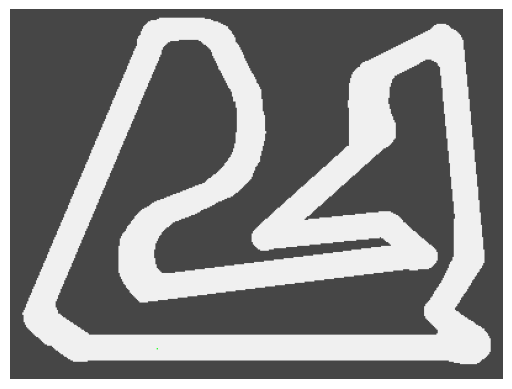

track shape: 300 400
start at coordinates: (119, 24)


In [12]:
path = "../tracks/03.png"

from matplotlib.image import imread
from PIL import Image

def info_from_real_color(tab):
    x,y,z = tab[0], tab[1], tab[2]
    if x==0 and y==0 and z==0:
        return 1
    elif x==255 and y==255 and z==255:
        return START_CHAR
    else:
        return 0

def create_track_info(path):
    img = Image.open(path)
    arr = np.array(img)
    return [[info_from_real_color(y) for y in x] for x in arr]

track_info = create_track_info(path)
track_1 = Track(track_info)
track_1.plot()
print("track shape:", track_1.height, track_1.width)
print("start at coordinates:", track_1.start)

### Car class

Car has $2$ main variable:
 - speed: $v$
 - alpha: $\alpha$ suppose to be between $0$ and $360$

To calculate the $x$-speed and $y$-speed we use the next formulas:
 - $v_x = v.cos(\alpha . \frac{\pi}{180})$
 - $v_y = v.sin(\alpha . \frac{\pi}{180})$

In [13]:
"""Constant"""


"""Class"""
class Car():
    def __init__(self, coor:Coor):
        self.coor: Coor = Coor((coor.x, coor.y))
        self.speed: float = 0
        self.alpha: float = 0 # The angle of the car according to unitary cicrle
        self.trajectory = [[Coor((coor.x, coor.y)),0]]
        self.previous_speed: float = 0

    def __str__(self):
        return "C[" + str(self.coor) + " " + str(self.speed) + " " + str(self.alpha) + "]"
    

    def accelerate(self, amont=1):
        """Increase speed of the car"""
        acceleration_constant = 1
        self.speed += acceleration_constant*amont

    def brake(self, amont=1):
        """Decrease speed of the car (can't drive backward)"""
        brake_constant = 1.5
        self.speed /= (brake_constant*amont)
        if self.speed < 0.01:
            self.speed = 0

    def turn(self, deg):
        """Change the current rotation of the car"""
        self.alpha += deg
        self.alpha = self.alpha % 360

    def get_speed_coor(self):
        cst: float = np.pi / 180
        dx: float = self.speed * np.cos(self.alpha * cst)
        dy: float = self.speed * np.sin(self.alpha * cst)
        return Coor((dx,dy))

    def move(self):
        """Change the coordinate of the care according to its speed and alpha"""
        speed_increase = 0
        if self.previous_speed < self.speed:
            speed_increase = 1
        elif self.previous_speed > self.speed:
            speed_increase = -1
        self.previous_speed = self.speed

        dx,dy = self.get_speed_coor().get()
        self.coor.x += dx
        self.coor.y += dy
        self.trajectory.append([Coor((self.coor.x, self.coor.y)), speed_increase])

    def dic(self):
        return {"coor":self.coor, "speed":self.speed, "alpha":self.alpha, "trajectory":self.trajectory}

    def plot(self, markersize=8, vector_constant=2, show_trajectory=False, head_width=1):
        """Plot the car and is speed vectors"""
        # Plot car
        x,y = self.coor.get()
        plt.plot(x, y, "o", color='blue', markersize=markersize)
        plt.axis("off")

        # Plot 
        if show_trajectory:
            liste_x = [i[0].x for i in self.trajectory]
            liste_y = [i[0].y for i in self.trajectory]

            for i in range(1, len(self.trajectory)):
                color = "yellow"
                if self.trajectory[i][1] == 1:
                    color = "limegreen"
                elif self.trajectory[i][1] == -1:
                    color = "red"
        
                plt.plot([liste_x[i-1], liste_x[i]], [liste_y[i-1], liste_y[i]], "-o", color=color, markersize=2)
                 

        # Plot car's directoin
        cst: float = np.pi / 180
        dx: float = np.cos(self.alpha * cst)
        dy: float = np.sin(self.alpha * cst)
        plt.arrow(x, y, dx/10, dy/10, head_width=head_width)
        plt.plot([x, x+ dx*self.speed*vector_constant], [y, y+ dy*self.speed*vector_constant], "-", color="red")


### Gym env

In [14]:
class MyEnv(Env):
    def __init__(self, track: Track):
        super(MyEnv, self).__init__()
        self.max_turn = 50
        # Define an action space ranging from 0 to 3
        self.track: Track = track
        self.car: Car = Car(track.start)

        self.canvas = np.array(self.track.color_track)


    def get_state(self):
        """Return actual state of the env"""
        state = np.array(self.track.info_track)
        return state, [val for _,val in self.car.dic().items()]

    def reset(self):
        """Reset the environment"""
        self.car = Car(self.track.start)
        return self.canvas

    def render(self, waiting_time=0.01):
        """Render the environment"""
        self.track.plot(hide=True)
        self.car.plot(show_trajectory=True)
        display.clear_output(wait=True)
        plt.show()
        time.sleep(waiting_time)
        
        
    def step(self, action):
        """Do a step, we suppose that the action is a possible one"""
        is_done = False
        reward = 0

        x,y = self.car.coor.get()
        previous_coor = Coor((x,y))
        if action[0]==-1:
            self.car.brake()
        elif action[0]==1:
            self.car.accelerate()
        self.car.turn(action[1])
        self.car.move()

        new_coor = self.car.coor
        reward += previous_coor.dist(new_coor)

        if not self.track.is_case_ridable(self.car.coor):
            reward = -100
            is_done = True

        return self.canvas, reward, is_done, []
    
    def random_action(self, p_accel=0.25, p_brake=0.25, p_turn=0.5):
        """Return random possible action according to probability"""
        action = [0,0]
        rd_accel = rd.random()
        if rd_accel <= p_accel:
            action[0] = 1
        elif rd_accel <= p_accel + p_brake:
            action[0] = -1
        
        if rd.random() <= p_turn:
            action[1] = ((-1)**(rd.randint(0,1))) * rd.randint(-self.max_turn, self.max_turn)
        return action

# Algo Gen

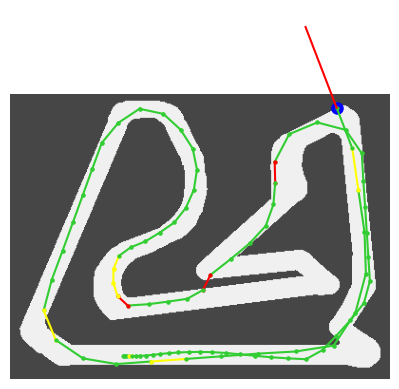

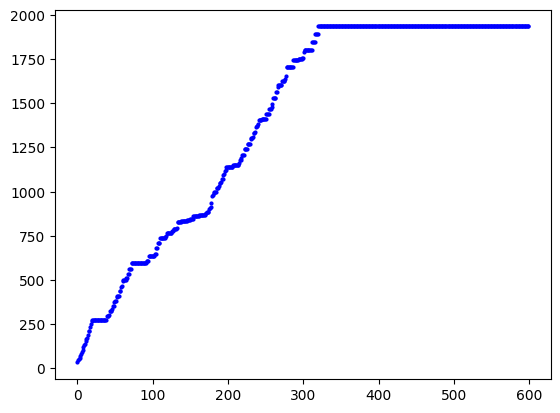

In [15]:
env = MyEnv(track_1)

class Indiv():
    def __init__(self, actions=[], sc=None):
        self.actions = [x for x in actions]
        # Not list of actions but list of Time -> action
        self.score = sc

def score(actions, show=False, wt=0.01):
    max_step = 300
    if len(actions) >= max_step:
        actions = actions[:max_step]
    env.reset()

    running = True
    sum_reward = 0
    step = 0
    while running:
        # Simulation
        action = [0, 0]
        if step < len(actions):
            action = actions[step]
        obs, reward, done, infos = env.step(action)
        sum_reward += reward

        # Render the game
        if show:
            env.render(waiting_time=wt)

        step += 1
        if (done == True) or (step >=max_step) or (step >= len(actions)) :
            running = False
    
    return sum_reward


def rd_action():
    return env.random_action()

def gen_indiv():
    len_actions = rd.randint(1, 10)
    indiv = Indiv([rd_action() for _ in range(len_actions)])
    indiv.score = score(indiv.actions)
    return indiv

    
def gen_pop():
    return [gen_indiv() for i in range(LEN_POP)]

def mutate_indiv(indiv: Indiv):    
    i1 = copy_indiv(indiv)
    x = rd.randint(0, len(i1.actions)-1)
    i1.actions[x] = rd_action()

    i2 = copy_indiv(indiv)
    x = rd.randint(0, len(i1.actions)-1)
    i2.actions.insert(x, rd_action())

    i3 = copy_indiv(indiv)
    x = rd.randint(0, len(i1.actions)-1)
    del i3.actions[x]

    liste_mutations = [i1, i2, i3]
    for indiv in liste_mutations:
        indiv.score = score(indiv.actions)
    return liste_mutations

def cross_over(indiv1: Indiv, indiv2: Indiv):
    co = Indiv()
    for i in range(max(len(indiv1.actions), len(indiv2.actions))):
        possible_acceleration = []
        turn = 0
        for indiv in [indiv1, indiv2]:
            if i < len(indiv.actions):
                possible_acceleration.append(indiv.actions[i][0])
                turn += indiv.actions[i][1]
        turn /= len(possible_acceleration)
        
        action = [rd.choice(possible_acceleration), turn]
        co.actions.append(action)
    co.score = score(co.actions)
    return co

def sort_pop(pop):
    pop.sort( key = lambda x: -x.score)

def copy_indiv(indiv: Indiv):
    return Indiv([x for x in indiv.actions], indiv.score)

def select_pop(pop):
    new_pop = []
    pourcentage = 0.25
    k = int( (1 + np.sqrt(1 + 8*pourcentage*LEN_POP)) / 2 ) 

    for i in range( int(0.2*LEN_POP) ):
        new_pop.append(pop[i])
        
    for i in range(k):
        for j in range(i+1, k):
            new_pop.append(cross_over(pop[i], pop[j]))
    

    epsilon_2 = 0.15
    a = epsilon_2 * LEN_POP
    if False:
        K = int(find_K(a))
        for i in range(K):
            for j in range((K-i)**2):
                new_indiv = mutate_indiv(pop[i])
                for id in new_indiv:
                    new_pop.append(id)
    else:
        for i in range(int(a)):
            new_indiv = mutate_indiv(pop[i])
            for id in new_indiv:
                new_pop.append(id)

    while (len(new_pop) < LEN_POP):
        new_pop.append(gen_indiv())

    return new_pop


LEN_POP = 800
def algo_gen():
    NB_GEN = 600
    pop = gen_pop()
    score_liste = []
    for gen in range(NB_GEN):
        sort_pop(pop)
        pop = select_pop(pop)

        if gen % 1 == 0:
            print(gen, end=" ")
        if (gen+1) % 100 == 0:
            print(pop[0].actions)
            score(pop[0].actions, show=True)
        score_liste.append(pop[0].score)
    
    for gen,sc in enumerate(score_liste):
        plt.plot(gen, sc, '-o', color='blue', markersize=2)
    plt.show()
    return pop[0]

        
best = algo_gen()

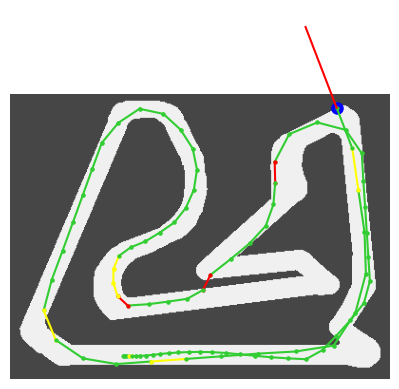

83
[[1, -0.9025594411996627], [1, -0.5679243978022397], [1, -0.2394715319675509], [0, 0.06623966022153027], [1, 1.625963181734897], [1, 1.6509417531898132], [1, 1.750055240370088], [1, 2.4144326546702315], [1, 0.41269547745010904], [1, -0.35888569984695273], [1, -1.7571434102422865], [1, -1.8499653445443638], [1, -1.388214603410777], [1, -1.9900150952287703], [1, -2.403427287206142], [1, -1.666149035779199], [1, -0.6380555085141566], [1, 0.7312049385527075], [1, 1.3962873760248158], [1, 0.8993859504585089], [1, 31.7251028061728], [1, 17.338477366346524], [1, 1.1643009347835687], [1, 4.5480822362915205], [1, 22.871057864278555], [1, 18.704725480172783], [1, 0.132476806640625], [1, 0.138214111328125], [1, 0.0115966796875], [1, -0.569671630859375], [1, 31.234375], [1, 40.78125], [1, 37.5], [1, 39.5], [-1, 29.146484375], [1, -6.1141291445906685], [1, -15.068416121227802], [1, -22.903867004190012], [1, -7.591386915540339], [1, -1.702548356132819], [-1, 25.270842398143706], [1, -34.362083881

In [16]:
score(best.actions, show=True, wt=0.001)
env.close()
print(len(best.actions))
print(best.actions)